In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [8]:
%matplotlib inline

Set some hypermarameters for later

In [9]:
rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [10]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [11]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [12]:
df.shape

(8192, 1)

Look at the data

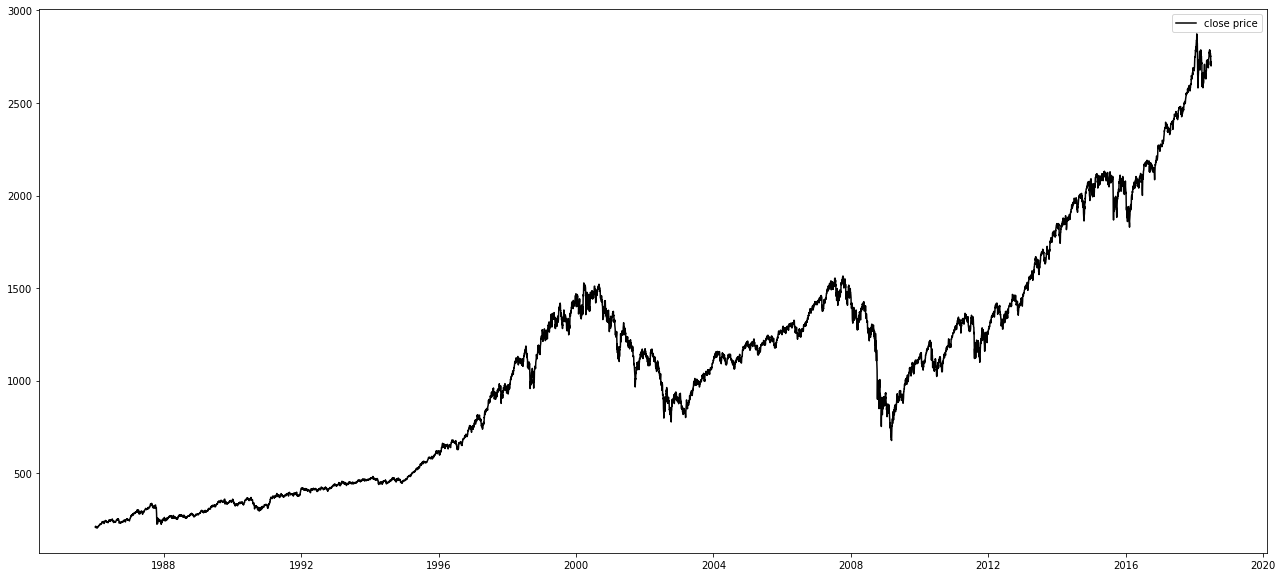

In [13]:
plt.plot(df, label='close price', color='black')
plt.legend()

Split the data

In [14]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7372, 1) (820, 1)


Using Standard Scaler

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler

The main idea is to normalize/standardize (mean = 0 and standard deviation = 1) your features/variables/columns of X before applying machine learning techniques.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7342, 30, 1)


Create a model

In [21]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 6607 samples, validate on 735 samples
Epoch 1/10
6607/6607 [==============================] - 8s 1ms/sample - loss: 0.1735 - val_loss: 0.4337
Epoch 2/10
6607/6607 [==============================] - 2s 270us/sample - loss: 0.0962 - val_loss: 0.2085
Epoch 3/10
6607/6607 [==============================] - 2s 248us/sample - loss: 0.0754 - val_loss: 0.2085
Epoch 4/10
6607/6607 [==============================] - 1s 226us/sample - loss: 0.0986 - val_loss: 0.1443
Epoch 5/10
6607/6607 [==============================] - 2s 235us/sample - loss: 0.1114 - val_loss: 0.1868
Epoch 6/10
6607/6607 [==============================] - 1s 222us/sample - loss: 0.1129 - val_loss: 0.2187
Epoch 7/10
6607/6607 [==============================] - 2s 264us/sample - loss: 0.1281 - val_loss: 0.2728
Epoch 8/10
6607/6607 [==============================] - 2s 230us/sample - loss: 0.1276 - val_loss: 0.2721
Epoch 9/10
6607/6607 [==============================] - 2s 228us/sample - loss: 0.1321 - val_loss: 0.1762
E

Let's look at the training results

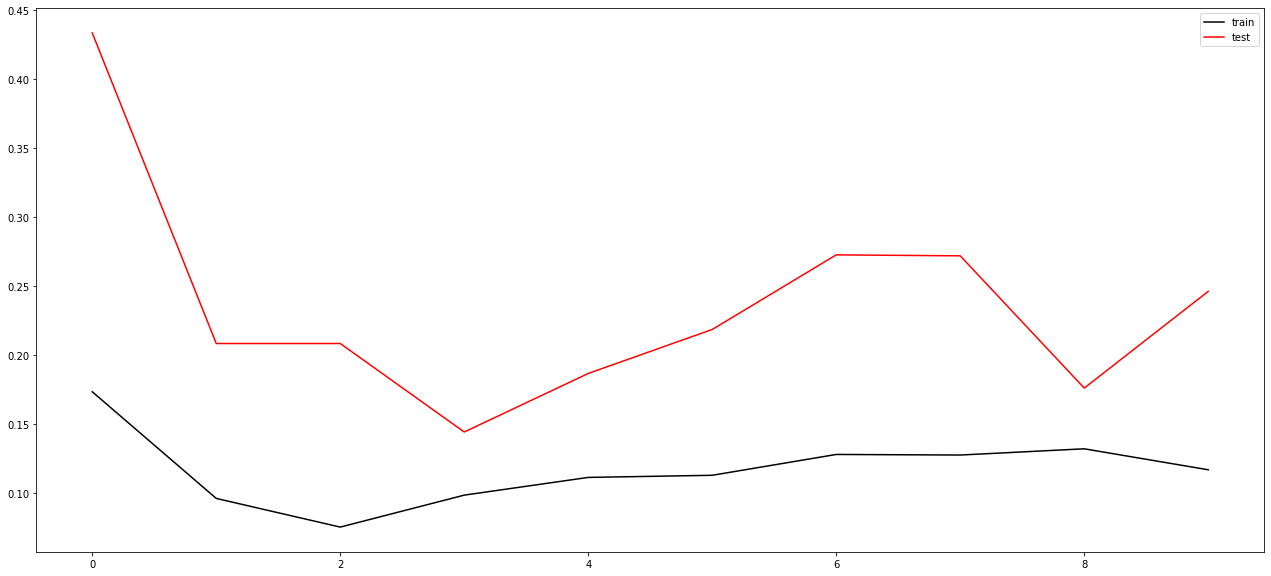

In [24]:
plt.plot(history.history['loss'], label='train', color = 'black')
plt.plot(history.history['val_loss'], label='test', color = 'red')
plt.legend()

In [25]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

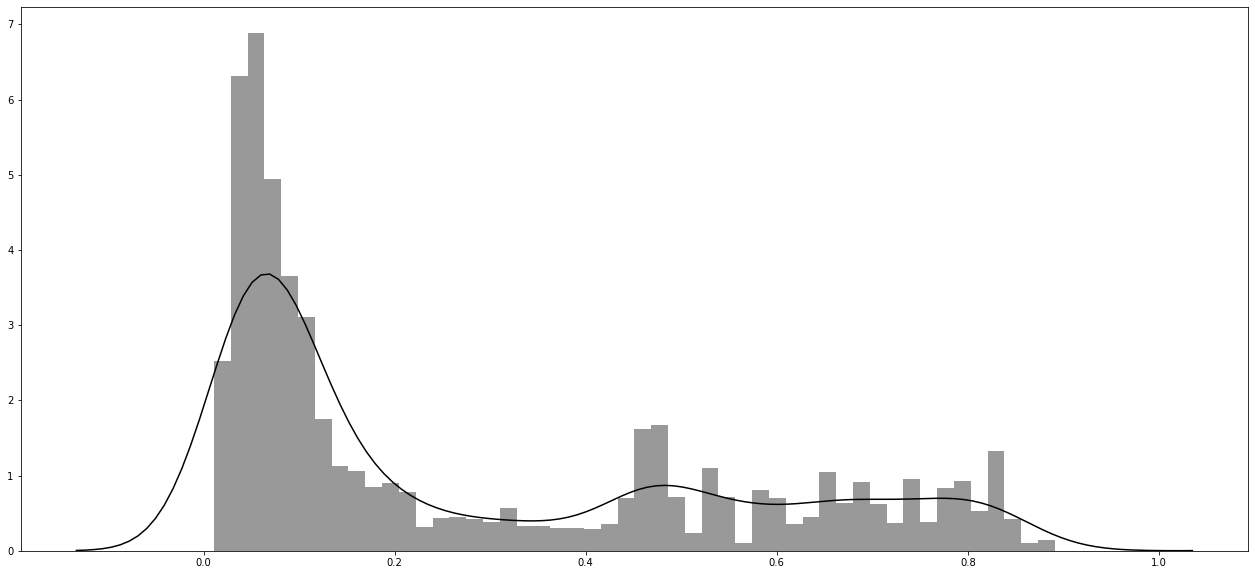

In [26]:
sns.distplot(train_mae_loss, bins=50, kde=True, color='black')

In [27]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [28]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

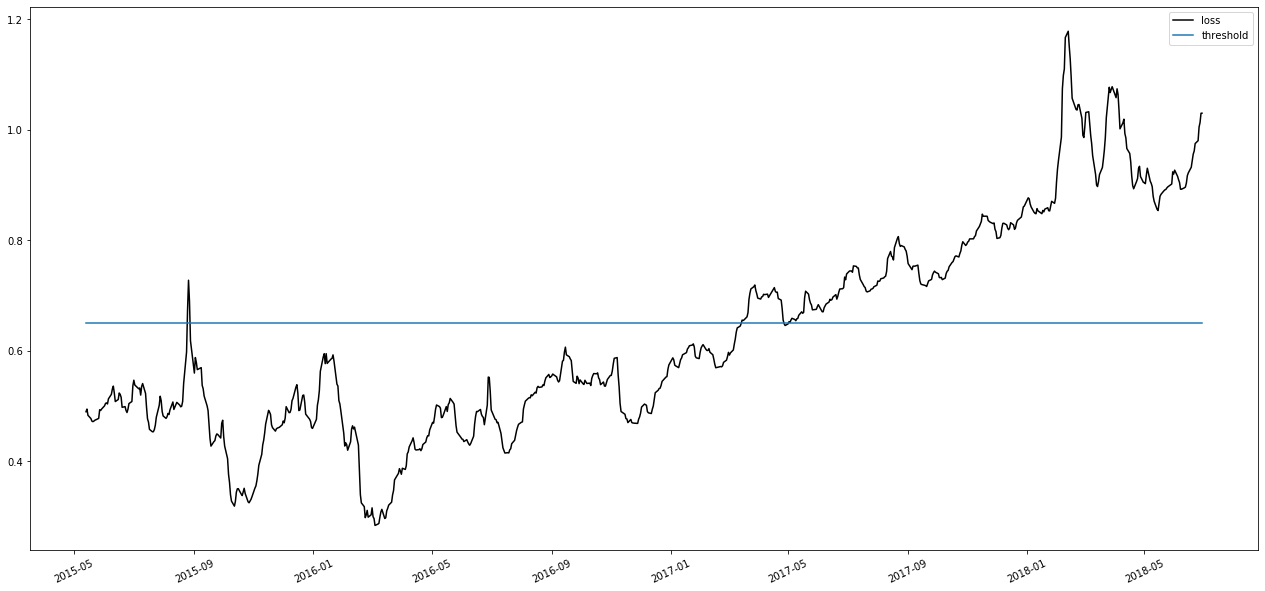

In [30]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss', color='black')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()

In [31]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2015-08-25,0.672888,0.65,True,1.938568
2015-08-26,0.727340,0.65,True,2.090148
2015-08-27,0.688540,0.65,True,2.188186
2017-03-15,0.655272,0.65,True,3.014908
2017-03-16,0.654478,0.65,True,3.006840


In [33]:
anomalies['anomaly'].value_counts()

True    327
Name: anomaly, dtype: int64

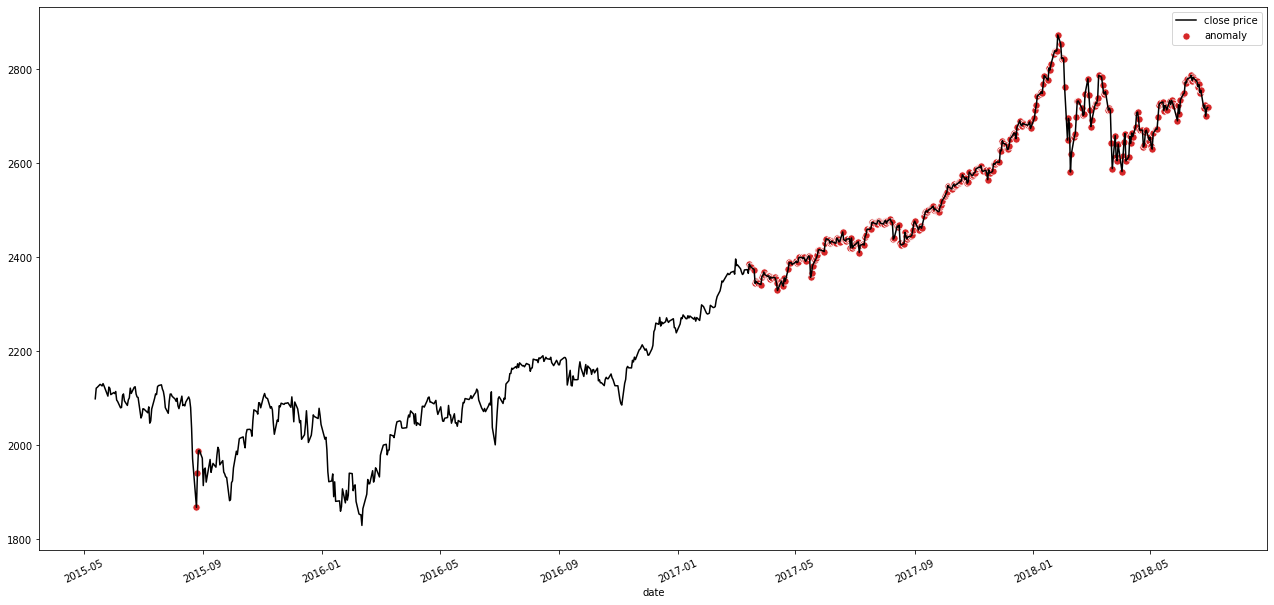

In [36]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price',
  color='black'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend()